In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go




# Lade das Datenset
charging_set = pd.read_csv("data/cleaned_charging_set_new.csv")
charging_set.head(3)



,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,userID,...,requestedDeparture_year,requestedDeparture_month,requestedDeparture_day,requestedDeparture_time,requestedDeparture_weekday,connectionDuration,chargingDuration,isRegistered,fullyCharged,parkingDuration
0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,194.0,...,2020,1,2,20:51:54,3,6.039167,4.378056,1,1,1.66
1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,4275.0,...,2020,1,2,23:31:50,3,9.025278,6.687500,1,1,2.34
2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,344.0,...,2020,1,2,14:56:35,3,10.713056,2.641944,1,1,8.07


# Hourly number of charging events
Visualized the total and site dependent number of charging events, as a starting point to begin analyzing the development of chargining events. Multiple visualisations were created in order to determine the most suited visualization option.


In [2]:
print(charging_set.columns)
# Anzahl der Lade-Events pro Tag berechnen
charging_set['connectionTime_time'] = pd.to_datetime(charging_set['connectionTime_time'])
charging_set['hour'] = charging_set['connectionTime_time'].dt.hour


events_at_day = charging_set.groupby('hour').size().reset_index(name='count')

# Count all loading-events over the available timeframe, ploted on hours of the day
fig = px.bar(
    events_at_day,
    x='hour',
    y='count',
    title='Loading-events over the day (siteID = all)',
    labels={'hour': 'Hour', 'count': 'Number of loading-events'}
)

# Layout adjustment
fig.update_traces(marker_color='#00008B')  # Color
fig.update_layout(
    title_font_size=18,
    legend_title_text="Legend",
    template="plotly_white"
)

# Show grafic
fig.show()


for site_id in [1, 2]:
    site_data = charging_set[charging_set['siteID'] == site_id]
    site_events_at_day = site_data.groupby('hour').size().reset_index(name='count')

    # Interactive visualization
    fig = px.bar(
        site_events_at_day,
        x='hour',
        y='count',
        title=f'Loading-events over the day (siteID = {site_id})',
        labels={'hour': 'Hour', 'count': 'Number of loading-events'},
    )

    fig.update_traces(marker_color='#1f77b4')

# Layout adjustment
    fig.update_layout(
        title_font_size=18,
        legend_title_text="Legend",
        template="plotly_white"
    )

    # Show grafic
    fig.show()

Index(['id', 'connectionTime', 'disconnectTime', 'doneChargingTime',
       'kWhDelivered', 'sessionID', 'siteID', 'spaceID', 'stationID', 'userID',
       'WhPerMile', 'kWhRequested', 'milesRequested', 'minutesAvailable',
       'modifiedAt', 'paymentRequired', 'requestedDeparture',
       'timeDiffParking', 'connectionTime_year', 'connectionTime_month',
       'connectionTime_day', 'connectionTime_time', 'connectionTime_weekday',
       'disconnectTime_year', 'disconnectTime_month', 'disconnectTime_day',
       'disconnectTime_time', 'disconnectTime_weekday',
       'doneChargingTime_year', 'doneChargingTime_month',
       'doneChargingTime_day', 'doneChargingTime_time',
       'doneChargingTime_weekday', 'modifiedAt_year', 'modifiedAt_month',
       'modifiedAt_day', 'modifiedAt_time', 'modifiedAt_weekday',
       'requestedDeparture_year', 'requestedDeparture_month',
       'requestedDeparture_day', 'requestedDeparture_time',
       'requestedDeparture_weekday', 'connectionDuration

### Observation
- Site 1 clearly dominates the total charging numbers. Therefore a visualization which directly compares Site 1 and Site 2 is necessary.

In [3]:
import pandas as pd
import plotly.express as px

# Print columns of the dataset
print(charging_set.columns)

# Ensure datetime conversion for connectionTime_time
charging_set['connectionTime_time'] = pd.to_datetime(charging_set['connectionTime_time'])
charging_set['hour'] = charging_set['connectionTime_time'].dt.hour

# Function to calculate hourly events combined across sites
def calculate_hourly_events_combined(data):
    hourly_data = []
    for site_id in data['siteID'].unique():
        site_data = data[data['siteID'] == site_id]
        for hour in range(24):
            event_count = len(site_data[site_data['hour'] == hour])
            hourly_data.append({'hour': hour, 'count': event_count, 'siteID': site_id})
    return pd.DataFrame(hourly_data)

# Calculate hourly events for all sites combined
hourly_events_combined = calculate_hourly_events_combined(charging_set)

# Ensure siteID is treated as a categorical variable
hourly_events_combined['siteID'] = hourly_events_combined['siteID'].astype(str)

# Define custom colors for the sites
custom_colors = {
    "1": '#4682B4',  # Darker Blue for Site 1
    "2": '#00008B'   # Dark Blue for Site 2
}

# Plot combined hourly events with site-specific colors
fig = px.bar(
    hourly_events_combined, x='hour', y='count', color='siteID', 
    title='Loading Events per Hour (Grouped by Site)',
    labels={'hour': 'Hour', 'count': 'Number of Loading Events', 'siteID': 'Site'},
    color_discrete_map=custom_colors,  # Apply custom colors
    barmode='group'
)

# Update layout for clear legend and x-axis
fig.update_layout(
    title_font_size=18,
    legend_title_text="Site",
    template="plotly_white",
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1  # Ensure every hour is displayed on the x-axis
    )
)

fig.show()

Index(['id', 'connectionTime', 'disconnectTime', 'doneChargingTime',
       'kWhDelivered', 'sessionID', 'siteID', 'spaceID', 'stationID', 'userID',
       'WhPerMile', 'kWhRequested', 'milesRequested', 'minutesAvailable',
       'modifiedAt', 'paymentRequired', 'requestedDeparture',
       'timeDiffParking', 'connectionTime_year', 'connectionTime_month',
       'connectionTime_day', 'connectionTime_time', 'connectionTime_weekday',
       'disconnectTime_year', 'disconnectTime_month', 'disconnectTime_day',
       'disconnectTime_time', 'disconnectTime_weekday',
       'doneChargingTime_year', 'doneChargingTime_month',
       'doneChargingTime_day', 'doneChargingTime_time',
       'doneChargingTime_weekday', 'modifiedAt_year', 'modifiedAt_month',
       'modifiedAt_day', 'modifiedAt_time', 'modifiedAt_weekday',
       'requestedDeparture_year', 'requestedDeparture_month',
       'requestedDeparture_day', 'requestedDeparture_time',
       'requestedDeparture_weekday', 'connectionDuration

In [4]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Print columns of the dataset
print(charging_set.columns)

# Ensure datetime conversion for connectionTime_time
charging_set['connectionTime_time'] = pd.to_datetime(charging_set['connectionTime_time'])
charging_set['hour'] = charging_set['connectionTime_time'].dt.hour

# Function to calculate hourly events combined across sites
def calculate_hourly_events_combined(data):
    hourly_data = []
    for site_id in data['siteID'].unique():
        site_data = data[data['siteID'] == site_id]
        for hour in range(24):
            event_count = len(site_data[site_data['hour'] == hour])
            hourly_data.append({'hour': hour, 'count': event_count, 'siteID': site_id})
    return pd.DataFrame(hourly_data)

# Calculate hourly events for all sites combined
hourly_events_combined = calculate_hourly_events_combined(charging_set)

# Ensure siteID is treated as a categorical variable
hourly_events_combined['siteID'] = hourly_events_combined['siteID'].astype(str)

# Calculate total events per hour (site 1 + site 2)
total_events = hourly_events_combined.groupby('hour')['count'].sum().reset_index()

# Define custom colors for the sites
custom_colors = {
    "1": '#4682B4',  # Darker Blue for Site 1
    "2": '#00008B'   # Dark Blue for Site 2
}

# Plot combined hourly events with site-specific colors
fig = px.bar(
    hourly_events_combined, x='hour', y='count', color='siteID', 
    title='Loading Events per Hour (Grouped by Site)',
    labels={'hour': 'Hour', 'count': 'Number of Loading Events', 'siteID': 'Site'},
    color_discrete_map=custom_colors,  # Apply custom colors
    barmode='group'
)

# Add total events as an orange line
fig.add_trace(
    go.Scatter(
        x=total_events['hour'], 
        y=total_events['count'], 
        mode='lines+markers', 
        name='Total Events',
        line=dict(color='orange', width=2)
    )
)

# Update layout for clear legend and x-axis
fig.update_layout(
    title_font_size=18,
    legend_title_text="Site",
    template="plotly_white",
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1  # Ensure every hour is displayed on the x-axis
    )
)

fig.show()

Index(['id', 'connectionTime', 'disconnectTime', 'doneChargingTime',
       'kWhDelivered', 'sessionID', 'siteID', 'spaceID', 'stationID', 'userID',
       'WhPerMile', 'kWhRequested', 'milesRequested', 'minutesAvailable',
       'modifiedAt', 'paymentRequired', 'requestedDeparture',
       'timeDiffParking', 'connectionTime_year', 'connectionTime_month',
       'connectionTime_day', 'connectionTime_time', 'connectionTime_weekday',
       'disconnectTime_year', 'disconnectTime_month', 'disconnectTime_day',
       'disconnectTime_time', 'disconnectTime_weekday',
       'doneChargingTime_year', 'doneChargingTime_month',
       'doneChargingTime_day', 'doneChargingTime_time',
       'doneChargingTime_weekday', 'modifiedAt_year', 'modifiedAt_month',
       'modifiedAt_day', 'modifiedAt_time', 'modifiedAt_weekday',
       'requestedDeparture_year', 'requestedDeparture_month',
       'requestedDeparture_day', 'requestedDeparture_time',
       'requestedDeparture_weekday', 'connectionDuration

## Further Observations:
- Site 1 significantly dominates the total numbers
- Total charging events peak at 14:00 with 7061 events
- Minimum is reached at 9:00 with 25 events
- Site 2 peaks 2 hours later than total peak (16:00)

## More Visualizations
In order to attain a broader picture of the hourly development, also the active charging events per hour are visualized

In [5]:
import pandas as pd
import plotly.express as px

# Convert datetime columns
charging_set['connectionTime'] = pd.to_datetime(charging_set['connectionTime'])
charging_set['disconnectTime'] = pd.to_datetime(charging_set['disconnectTime'])

# Function to calculate active events per hour
def calculate_hourly_activity(data, site_id=None):
    if site_id is not None:
        data = data[data['siteID'] == site_id]
    return pd.DataFrame([
        {'hour': hour, 'count': len(data[
            (data['connectionTime'].dt.hour <= hour) & 
            (data['disconnectTime'].dt.hour >= hour)
        ])} for hour in range(24)
    ])

# Plot function
def plot_activity(activity_df, title, color='#00008B'):
    fig = px.bar(
        activity_df, x='hour', y='count', title=title, 
        labels={'hour': 'Hour', 'count': 'Active Charging Events'}
    )
    fig.update_traces(marker_color=color)
    fig.update_layout(title_font_size=18, legend_title_text="Legend", template="plotly_white")
    fig.show()

# Overall activity
hourly_activity = calculate_hourly_activity(charging_set)
plot_activity(hourly_activity, 'Active Charging Events per Hour (siteID = all)')

# Activity per site
for site_id in [1, 2]:
    site_activity = calculate_hourly_activity(charging_set, site_id)
    plot_activity(site_activity, f'Active Charging Events per Hour (siteID = {site_id})', color='#1f77b4')


## Adjustment
As expected total active charging events are also dominated by site 1. This necessitates a differentiation of sites within one visualization.

In [6]:
def calculate_hourly_activity_combined(data):
    hourly_data = []
    for site_id in data['siteID'].unique():
        site_data = data[data['siteID'] == site_id]
        for hour in range(24):
            active_count = len(site_data[(site_data['connectionTime'].dt.hour <= hour) & (site_data['disconnectTime'].dt.hour >= hour)])
            hourly_data.append({'hour': hour, 'count': active_count, 'siteID': site_id})
    return pd.DataFrame(hourly_data)

# Calculate activity for both sites combined
hourly_activity_combined = calculate_hourly_activity_combined(charging_set)

# Ensure siteID is treated as a categorical variable
hourly_activity_combined['siteID'] = hourly_activity_combined['siteID'].astype(str)

# Calculate total active events per hour (site 1 + site 2)
total_activity = hourly_activity_combined.groupby('hour')['count'].sum().reset_index()

# Define custom colors for the sites
custom_colors = {
    "1": '#4682B4',  # Darker Blue for Site 1
    "2": '#00008B'   # Dark Blue for Site 2
}

# Plot with different colors for each site
fig = px.bar(
    hourly_activity_combined, x='hour', y='count', color='siteID', 
    title='Active Charging Events per Hour (Grouped by Site)',
    labels={'hour': 'Hour', 'count': 'Active Charging Events', 'siteID': 'Site'},
    color_discrete_map=custom_colors,  # Apply custom colors
    barmode='group'
)

# Add total active events as an orange line
import plotly.graph_objects as go
fig.add_trace(
    go.Scatter(
        x=total_activity['hour'], 
        y=total_activity['count'], 
        mode='lines+markers', 
        name='Total Active Events',
        line=dict(color='orange', width=2)
    )
)

# Update layout for clear legend and x-axis
fig.update_layout(
    title_font_size=18,
    legend_title_text="Site",
    template="plotly_white",
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1  # Ensure every hour is displayed on the x-axis
    )
)

fig.show()

## Observation
- The peak duration is much longer and constant compared to the previous visualization
- Peaking period: 13:00 - 23:00

# New visualization: Total charging events distributed over the months
This visualization is done to identify any seasonal trends or patterns

In [7]:
# Aggregation on months
month_names = {
    1: "January", 2: "February", 3: "March", 4: "April", 
    5: "May", 6: "June", 7: "July", 8: "August",
    9: "September", 10: "October", 11: "November", 12: "December"
}

events_per_month = charging_set.groupby('connectionTime_month').size().reset_index(name='count')

# Add month names
events_per_month['month_name'] = events_per_month['connectionTime_month'].map(month_names)

# Count all loading-events over the available timeframe, ploted on hours of the day
fig = px.bar(
    events_per_month,
    x='month_name',
    y='count',
    title='Loading-events per month (sideID = all)',
    labels={'hour': 'Month', 'count': 'Number of loading-events'}
)

# Layout adjustment
fig.update_traces(marker_color='#FF8C00')  # Color
fig.update_layout(
    title_font_size=18,
    legend_title_text="Legend",
    template="plotly_white"
)

# Show grafic
fig.show()



## Observation
- Rather constant development
- Peak in January
- Minimum in September

## Adjsutment
Differentiate between site 1 and site 2

In [8]:
# Aggregation on months
month_names = {
    1: "January", 2: "February", 3: "March", 4: "April", 
    5: "May", 6: "June", 7: "July", 8: "August",
    9: "September", 10: "October", 11: "November", 12: "December"
}

# Group by month and site
events_per_month = charging_set.groupby(['connectionTime_month', 'siteID']).size().reset_index(name='count')

# Add month names
events_per_month['month_name'] = events_per_month['connectionTime_month'].map(month_names)

# Calculate total events per month by adding site 1 and site 2
total_events_per_month = events_per_month.groupby('connectionTime_month')['count'].sum().reset_index()
total_events_per_month['month_name'] = total_events_per_month['connectionTime_month'].map(month_names)

# Ensure siteID is treated as a categorical variable
events_per_month['siteID'] = events_per_month['siteID'].astype(str)

# Define custom colors for the sites
custom_colors = {
    "1": '#4682B4',  # Darker Blue for Site 1
    "2": '#00008B'   # Dark Blue for Site 2
}

# Plot events per site with grouped bars
fig = px.bar(
    events_per_month, 
    x='month_name', 
    y='count', 
    color='siteID',
    title='Loading Events per Month (Grouped by Site)',
    labels={'month_name': 'Month', 'count': 'Number of Loading Events', 'siteID': 'Site'},
    color_discrete_map=custom_colors,
    barmode='group'
)

# Add total events as an orange line
import plotly.graph_objects as go
fig.add_trace(
    go.Scatter(
        x=total_events_per_month['month_name'], 
        y=total_events_per_month['count'], 
        mode='lines+markers', 
        name='Total Loading Events',
        line=dict(color='orange', width=2)
    )
)

# Layout adjustment
fig.update_layout(
    title_font_size=18,
    legend_title_text="Site",
    template="plotly_white"
)

# Show graphic
fig.show()

## Observation
- Site 2 dominates in Summer Months most likely due to increased tourism



## Adjustment
- Choosing a different visualization option, to better display peaks

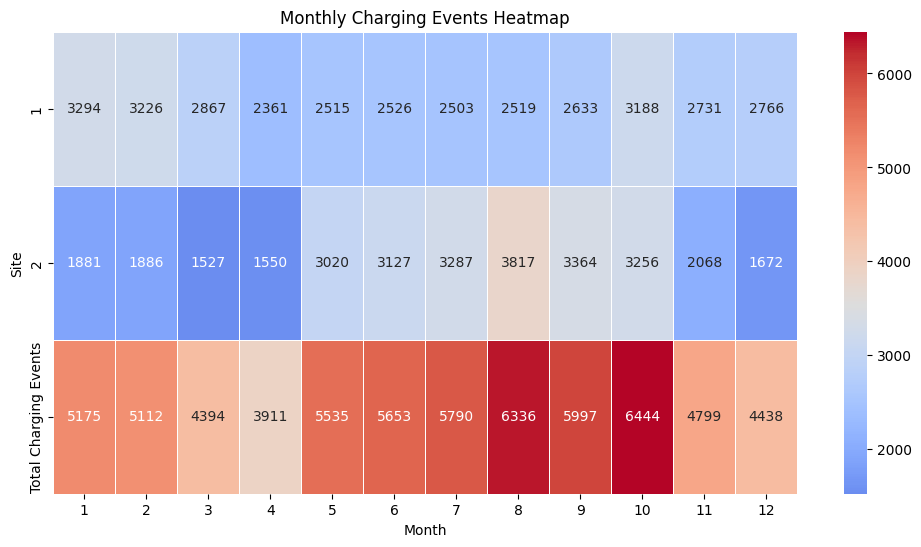

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Lade das bereinigte Charging-Set
df = pd.read_csv("data/cleaned_charging_set_new.csv")

# Monatsnamen definieren
month_names = {
    1: "January", 2: "February", 3: "March", 4: "April", 
    5: "May", 6: "June", 7: "July", 8: "August",
    9: "September", 10: "October", 11: "November", 12: "December"
}

# Gruppierung nach Monat und Standort
events_per_month = df.groupby(['connectionTime_month', 'siteID']).size().reset_index(name='count')

# Monatsnamen hinzufügen
events_per_month['month_name'] = events_per_month['connectionTime_month'].map(month_names)

# Gesamte Ladeereignisse pro Monat berechnen
total_events_per_month = events_per_month.groupby('connectionTime_month')['count'].sum().reset_index()
total_events_per_month['month_name'] = total_events_per_month['connectionTime_month'].map(month_names)
total_events_per_month['siteID'] = 'Total Charging Events'

# Heatmap-Daten vorbereiten
df_pivot = events_per_month.pivot(index='siteID', columns='connectionTime_month', values='count').fillna(0)
df_pivot = pd.concat([df_pivot, total_events_per_month.pivot(index='siteID', columns='connectionTime_month', values='count')])

# Spalten (Monate) chronologisch sortieren
df_pivot = df_pivot.reindex(sorted(df_pivot.columns), axis=1)

# Heatmap erstellen mit Seaborn
plt.figure(figsize=(12, 6))
sns.heatmap(df_pivot, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".0f", center=df_pivot.mean().mean())

# Achsentitel setzen
plt.title("Monthly Charging Events Heatmap")
plt.xlabel("Month")
plt.ylabel("Site")

# Heatmap anzeigen
plt.show()

## Obersvations
- Site 1 dominates
- Clear peaks in January and February

## Adjustment
Now we visualize the number of total charging events over all months of the timespan to identify any other trends or patterns or significant periods

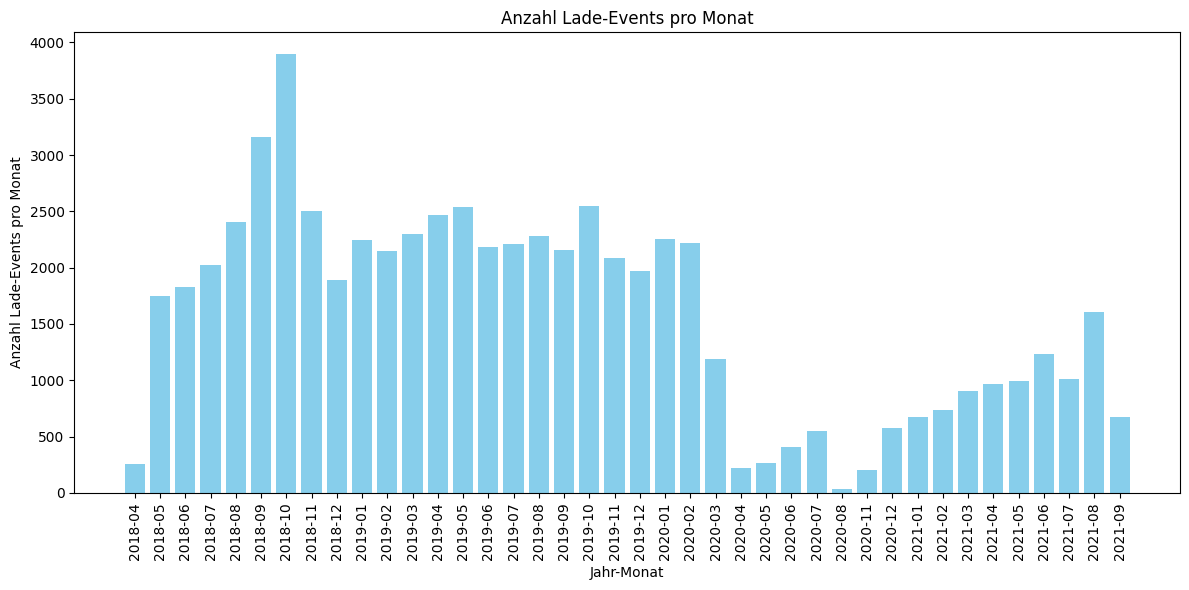

In [10]:
charging_set['connectionTime'] = pd.to_datetime(charging_set['connectionTime'])

# Jahr und Monat extrahieren
charging_set['year'] = charging_set['connectionTime_year']
charging_set['month'] = charging_set['connectionTime_month']

# Berechnung der durchschnittlichen Temperatur pro Jahr und Monat
avg_temperatures = charging_set.groupby(['year', 'month']).size().reset_index(name='count')

# Erstellen des Balkendiagramms
plt.figure(figsize=(12, 6))
# Kombiniere Jahr und Monat für die X-Achse, z.B. '2022-01' für Januar 2022
avg_temperatures['year_month'] = avg_temperatures['year'].astype(str) + '-' + avg_temperatures['month'].astype(str).str.zfill(2)

# Erstellen des Balkendiagramms
plt.bar(avg_temperatures['year_month'], avg_temperatures['count'], color='skyblue')

# Titel und Beschriftungen
plt.title('Anzahl Lade-Events pro Monat')
plt.xlabel('Jahr-Monat')
plt.ylabel('Anzahl Lade-Events pro Monat')

# Optional: X-Achse formatieren (dreh die Labels, damit sie lesbar sind)
plt.xticks(rotation=90)

# Layout optimieren
plt.tight_layout()

# Diagramm anzeigen
plt.show()

## Observation
- Generally volatile development
- Peaking period from May 2018 until February 2020
- Abrupt decrease beginning March 2020
- Total charging numbers do not fully recover from this point on

## Adjustment
Once again differentiate between sites to better understand development

In [11]:
charging_set['connectionTime'] = pd.to_datetime(charging_set['connectionTime'])

# Jahr und Monat extrahieren
charging_set['year'] = charging_set['connectionTime'].dt.year
charging_set['month'] = charging_set['connectionTime'].dt.month

# Gruppieren nach Jahr, Monat und Site
avg_temperatures = charging_set.groupby(['year', 'month', 'siteID']).size().reset_index(name='count')

# Kombiniere Jahr und Monat für die X-Achse, z.B. '2022-01' für Januar 2022
avg_temperatures['year_month'] = avg_temperatures['year'].astype(str) + '-' + avg_temperatures['month'].astype(str).str.zfill(2)

# Gesamtevents über alle Sites berechnen
total_avg_temperatures = avg_temperatures.groupby('year_month', as_index=False)['count'].sum()

# Ensure siteID is treated as a categorical variable
avg_temperatures['siteID'] = avg_temperatures['siteID'].astype(str)

# Define custom colors for the sites
custom_colors = {
    "1": '#4682B4',  # Darker Blue for Site 1
    "2": '#00008B'   # Dark Blue for Site 2
}

# Plot events per site with grouped bars
import plotly.express as px
fig = px.bar(
    avg_temperatures, 
    x='year_month', 
    y='count', 
    color='siteID',
    title='Charging Events per Month (Grouped by Site)',
    labels={'year_month': 'Year-Month', 'count': 'Number of Charging Events', 'siteID': 'Site'},
    color_discrete_map=custom_colors,
    barmode='group'
)

# Add total events as an orange line
import plotly.graph_objects as go
fig.add_trace(
    go.Scatter(
        x=total_avg_temperatures['year_month'], 
        y=total_avg_temperatures['count'], 
        mode='lines+markers', 
        name='Total Charging Events',
        line=dict(color='orange', width=2)
    )
)

# Layout adjustment
fig.update_layout(
    title_font_size=18,
    legend_title_text="Site",
    template="plotly_white",
    xaxis=dict(tickangle=90)
)

# Show graphic
fig.show()

## Observation
- Site 1 has no records until October 2018
- Considering the entire timeframe the sites are overall more balanced in terms of their numbers

# New Visualization: Distribution over weekdays
Visualizing the total charging numbers over the weekdays to identify patterns or trends happening on the weekly basis

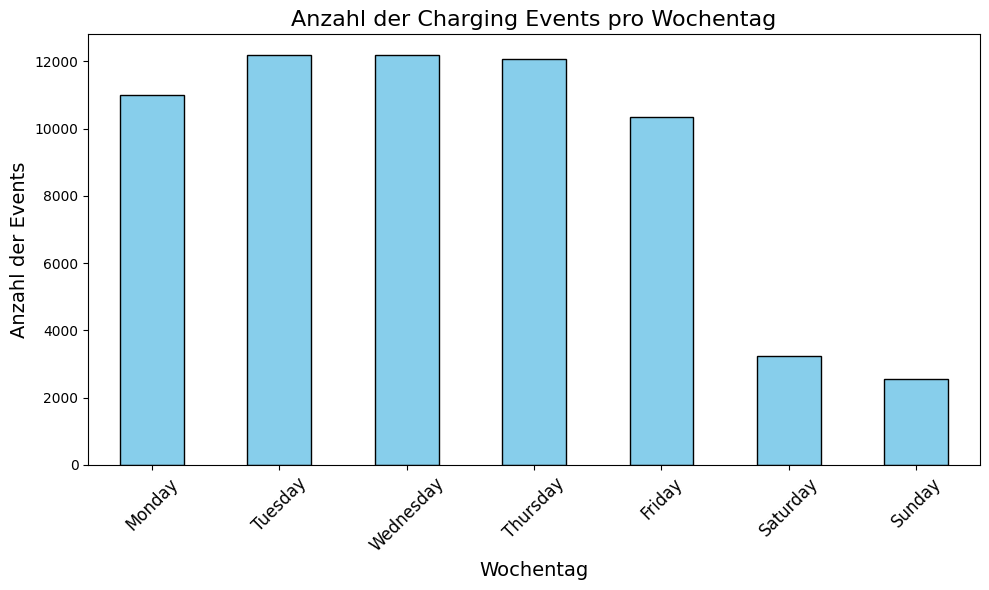

In [12]:
# Konvertiere die Spalte `connectionTime_date` in ein Datetime-Format
charging_set['connection_date'] = pd.to_datetime(charging_set['connectionTime'])

# Extrahiere den Wochentag
charging_set['weekday'] = charging_set['connection_date'].dt.day_name()

# Zähle die Anzahl der Charging Events pro Wochentag
weekday_counts = charging_set['weekday'].value_counts()

# Sortiere die Wochentage in der korrekten Reihenfolge
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = weekday_counts.reindex(weekday_order)

# Balkendiagramm erstellen
plt.figure(figsize=(10, 6))
weekday_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Anzahl der Charging Events pro Wochentag', fontsize=16)
plt.xlabel('Wochentag', fontsize=14)
plt.ylabel('Anzahl der Events', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()

# Diagramm anzeigen
plt.show()


## Adjustment
We visualize over the weekdays and further differentiate between sites in order to identify which site is public and which site is private.

In [13]:
# Konvertiere die Spalte `connectionTime_date` in ein Datetime-Format
charging_set['connection_date'] = pd.to_datetime(charging_set['connectionTime'])

# Extrahiere den Wochentag
charging_set['weekday'] = charging_set['connection_date'].dt.day_name()

# Group by weekday and site
weekday_counts = charging_set.groupby(['weekday', 'siteID']).size().reset_index(name='count')

# Sortiere die Wochentage in der korrekten Reihenfolge
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts['weekday'] = pd.Categorical(weekday_counts['weekday'], categories=weekday_order, ordered=True)
weekday_counts = weekday_counts.sort_values('weekday')

# Berechne die Gesamtanzahl der Events pro Wochentag
total_weekday_counts = weekday_counts.groupby('weekday')['count'].sum().reset_index()

# Ensure siteID is treated as a categorical variable
weekday_counts['siteID'] = weekday_counts['siteID'].astype(str)

# Define custom colors for the sites
custom_colors = {
    "1": '#4682B4',  # Darker Blue for Site 1
    "2": '#00008B'   # Dark Blue for Site 2
}

# Plot events per site with grouped bars
fig = px.bar(
    weekday_counts, 
    x='weekday', 
    y='count', 
    color='siteID',
    title='Charging Events per Weekday (Grouped by Site)',
    labels={'weekday': 'Weekday', 'count': 'Number of Charging Events', 'siteID': 'Site'},
    color_discrete_map=custom_colors,
    barmode='group'
)

# Add total events as an orange line
import plotly.graph_objects as go
fig.add_trace(
    go.Scatter(
        x=total_weekday_counts['weekday'], 
        y=total_weekday_counts['count'], 
        mode='lines+markers', 
        name='Total Charging Events',
        line=dict(color='orange', width=2)
    )
)

# Layout adjustment
fig.update_layout(
    title_font_size=18,
    legend_title_text="Site",
    template="plotly_white"
)

# Show graphic
fig.show()

## Obersvations
- Site 1 shows higher charging numbers during workdays
- Site 2 shows higher charging numbers at the weekend
- This solidifies the assumption that site 1 is public, since naturally work is usually performed during the workdays

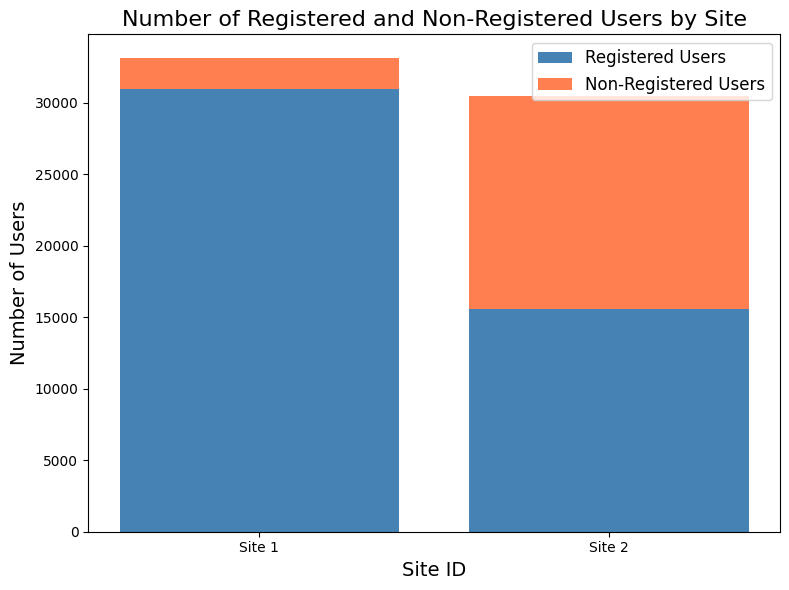

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV-Datei einlesen
# charging_set = pd.read_csv("data/cleaned_charging_set_new.csv")

# Daten für Site 1 und Site 2 filtern
site_data = charging_set[charging_set['siteID'].isin([1, 2])]

# Gruppieren nach 'siteID' und 'isRegistered' und Zählen der Einträge
site_user_counts = site_data.groupby(['siteID', 'isRegistered']).size().unstack(fill_value=0)

# Barplot-Daten vorbereiten
site_ids = site_user_counts.index
registered_counts = site_user_counts[1]  # Registrierte Benutzer
non_registered_counts = site_user_counts[0] if 0 in site_user_counts.columns else [0] * len(site_ids)  # Nicht registrierte Benutzer

# Gestapeltes Barchart erstellen
fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(site_ids, registered_counts, label='Registered Users', color='#4682B4')
ax.bar(site_ids, non_registered_counts, bottom=registered_counts, label='Non-Registered Users', color='#FF7F50')

# Achsenbeschriftung und Titel
ax.set_xlabel('Site ID', fontsize=14)
ax.set_ylabel('Number of Users', fontsize=14)
ax.set_title('Number of Registered and Non-Registered Users by Site', fontsize=16)

# Achsenticks und Legende
ax.set_xticks(site_ids)
ax.set_xticklabels([f'Site {int(site)}' for site in site_ids])
ax.legend(fontsize=12)

# Layout und Plot anzeigen
plt.tight_layout()
plt.show()

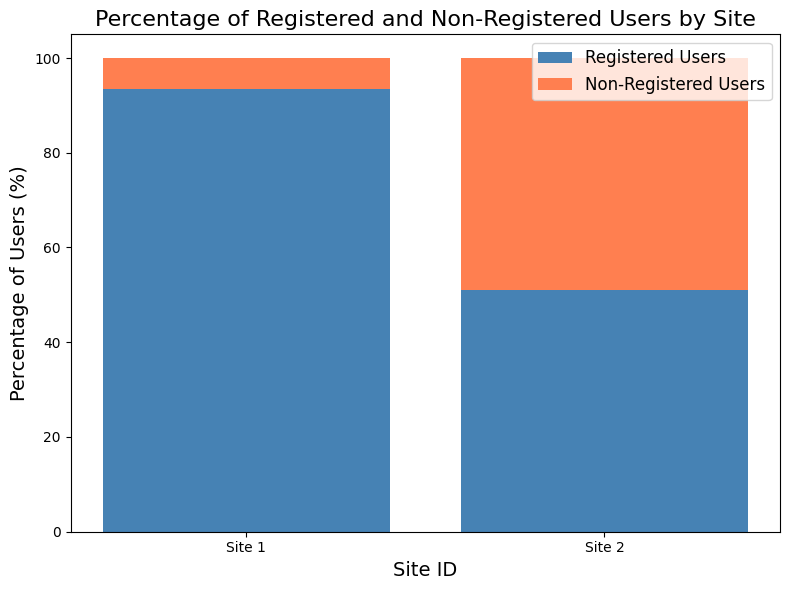

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV-Datei einlesen
# charging_set = pd.read_csv("data/cleaned_charging_set_new.csv")

# Daten für Site 1 und Site 2 filtern
site_data = charging_set[charging_set['siteID'].isin([1, 2])]

# Gruppieren nach 'siteID' und 'isRegistered' und Zählen der Einträge
site_user_counts = site_data.groupby(['siteID', 'isRegistered']).size().unstack(fill_value=0)

# Prozentuale Aufteilung berechnen
site_user_percentages = site_user_counts.div(site_user_counts.sum(axis=1), axis=0) * 100

# Barplot-Daten vorbereiten
site_ids = site_user_percentages.index
registered_percentages = site_user_percentages[1]  # Prozentual registrierte Benutzer
non_registered_percentages = site_user_percentages[0] if 0 in site_user_percentages.columns else [0] * len(site_ids)  # Prozentual nicht registrierte Benutzer

# Gestapeltes Barchart erstellen
fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(site_ids, registered_percentages, label='Registered Users', color='#4682B4')
ax.bar(site_ids, non_registered_percentages, bottom=registered_percentages, label='Non-Registered Users', color='#FF7F50')

# Achsenbeschriftung und Titel
ax.set_xlabel('Site ID', fontsize=14)
ax.set_ylabel('Percentage of Users (%)', fontsize=14)
ax.set_title('Percentage of Registered and Non-Registered Users by Site', fontsize=16)

# Achsenticks und Legende
ax.set_xticks(site_ids)
ax.set_xticklabels([f'Site {int(site)}' for site in site_ids])
ax.legend(fontsize=12)

# Layout und Plot anzeigen
plt.tight_layout()
plt.show()

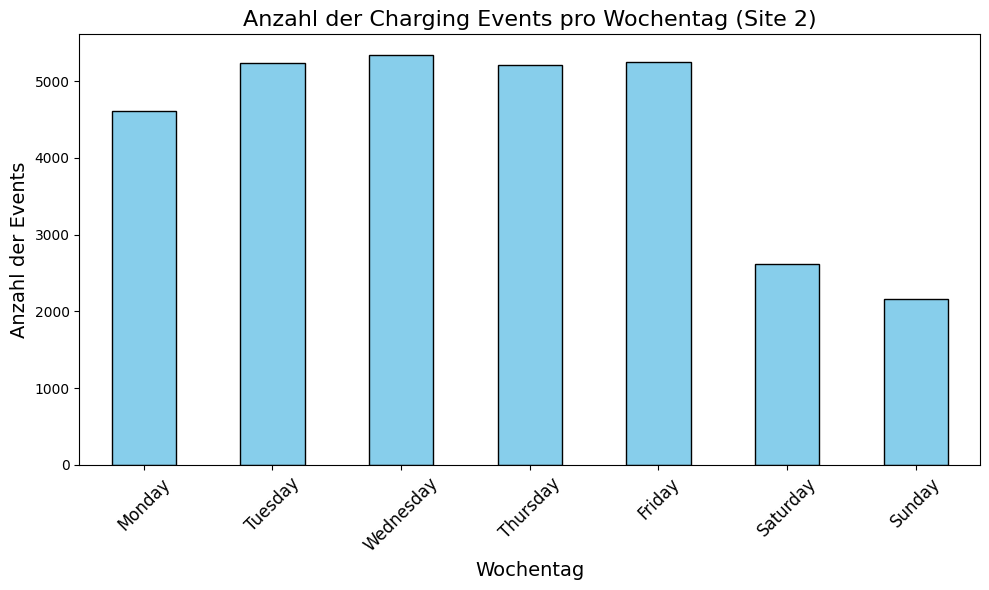

In [16]:
site_data = charging_set[charging_set['siteID'] == 2]

# Konvertiere die Spalte `connectionTime_date` in ein Datetime-Format
site_data['connection_date'] = pd.to_datetime(site_data['connectionTime'])

# Extrahiere den Wochentag
site_data['weekday'] = site_data['connection_date'].dt.day_name()

# Zähle die Anzahl der Charging Events pro Wochentag
weekday_counts = site_data['weekday'].value_counts()

# Sortiere die Wochentage in der korrekten Reihenfolge
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = weekday_counts.reindex(weekday_order)

# Balkendiagramm erstellen
plt.figure(figsize=(10, 6))
weekday_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Anzahl der Charging Events pro Wochentag (Site 2)', fontsize=16)
plt.xlabel('Wochentag', fontsize=14)
plt.ylabel('Anzahl der Events', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()

# Diagramm anzeigen
plt.show()


# New Visualization
After examining the development over the months, we also examine the development over the season, which are grouped by month and not by specific date.This should show no real surprises after having analyzed the distribution over the months but might still visualize new patterns that were hidden when just considering the months. 

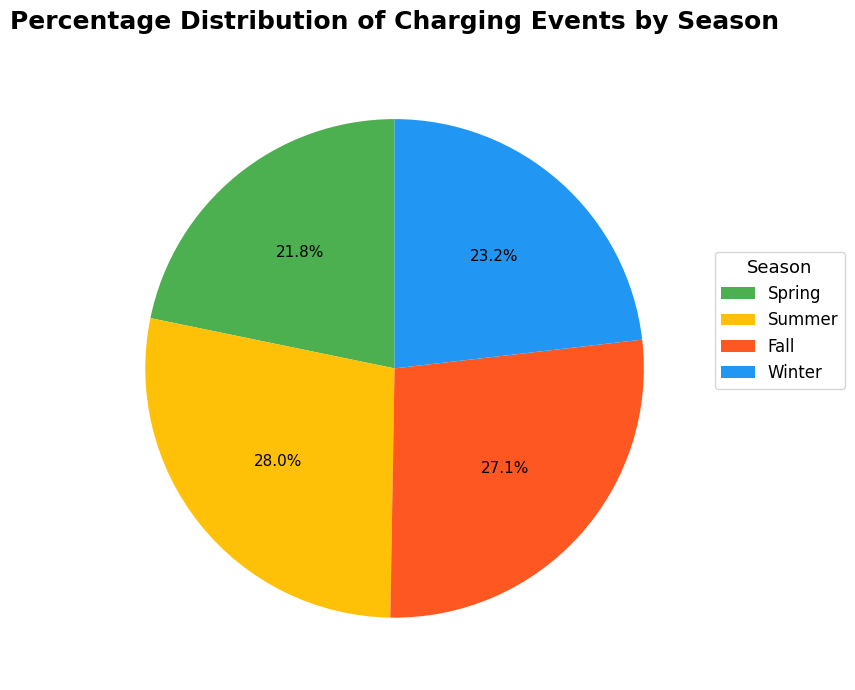

In [17]:


charging_set = pd.read_csv("data/cleaned_charging_set_new.csv")
import pandas as pd
import matplotlib.pyplot as plt

# Read data
charging_set = pd.read_csv("data/cleaned_charging_set_new.csv")

# Convert connection time to datetime format
charging_set['connectionTime'] = pd.to_datetime(charging_set['connectionTime'])

# Aggregate data by month
events_per_month = charging_set.groupby(charging_set['connectionTime'].dt.month).size().reset_index(name='count')
events_per_month.rename(columns={'connectionTime': 'month'}, inplace=True)

# Map months to seasons
def map_month_to_season(month):
    if month in [12, 1, 2]:  # Winter
        return 'Winter'
    elif month in [3, 4, 5]:  # Spring
        return 'Spring'
    elif month in [6, 7, 8]:  # Summer
        return 'Summer'
    elif month in [9, 10, 11]:  # Fall
        return 'Fall'

# Add a "season" column
events_per_month['season'] = events_per_month['month'].apply(map_month_to_season)

# Aggregate events by season
events_per_season = events_per_month.groupby('season')['count'].sum().reindex(['Spring', 'Summer', 'Fall', 'Winter'])

# Colors for the seasons (with a professional look)
colors = ['#4CAF50', '#FFC107', '#FF5722', '#2196F3']  # Green, Yellow, Orange, Blue

# Create pie chart
fig, ax = plt.subplots(figsize=(10, 7))
wedges, texts, autotexts = ax.pie(
    events_per_season,
    autopct=lambda pct: f'{pct:.1f}%',  # Format percentages to 1 decimal place
    startangle=90,
    colors=colors,
    textprops={'fontsize': 11, 'color': 'black'}
)

# Add title
plt.title(
    'Percentage Distribution of Charging Events by Season',
    fontsize=18,
    weight='bold',
    pad=20
)

# Add legend
ax.legend(
    wedges,
    events_per_season.index,
    title="Season",
    loc="upper left",
    bbox_to_anchor=(1, 0.7),
    fontsize=12,
    title_fontsize=13
)

# Remove default Y-axis label
plt.ylabel('')

# Adjust layout for better spacing
plt.tight_layout()

# Save the chart as an image (optional)
# plt.savefig("charging_events_by_season.png", dpi=300, bbox_inches='tight')

# Display chart
plt.show()

## Oberservations
- No surprises
- Summer is the season which records the most charging events
- April is the season which records the fewest charging events

## Adjustment
Differentiate between sites to identify trends or patterns over the months which are site dependent

In [18]:
charging_set['connectionTime'] = pd.to_datetime(charging_set['connectionTime'])

# Aggregation auf Monatsbasis mit Site-Informationen
events_per_month = charging_set.groupby([charging_set['connectionTime'].dt.month, 'siteID']).size().reset_index(name='count')
events_per_month.rename(columns={'connectionTime': 'month'}, inplace=True)

# Mapping von Monaten zu Saisons
def map_month_to_season(month):
    if month in [12, 1, 2]:  # Winter
        return 'Winter'
    elif month in [3, 4, 5]:  # Spring
        return 'Spring'
    elif month in [6, 7, 8]:  # Summer
        return 'Summer'
    elif month in [9, 10, 11]:  # Fall
        return 'Fall'

# Hinzufügen einer "season"-Spalte
events_per_month['season'] = events_per_month['month'].apply(map_month_to_season)

# Aggregation der Events auf Basis der Saison je Site
events_per_season = events_per_month.groupby(['season', 'siteID'])['count'].sum().reset_index()
events_per_season['season'] = pd.Categorical(events_per_season['season'], categories=['Spring', 'Summer', 'Fall', 'Winter'], ordered=True)

# Berechnung der Gesamtevents pro Saison durch Addition von Site 1 und Site 2
total_events_per_season = events_per_season.groupby('season', as_index=False)['count'].sum()

# Ensure siteID is treated as a categorical variable
events_per_season['siteID'] = events_per_season['siteID'].astype(str)

# Define custom colors for the sites
custom_colors = {
    "1": '#4682B4',  # Darker Blue for Site 1
    "2": '#00008B'   # Dark Blue for Site 2
}

# Plot events per site with grouped bars
fig = px.bar(
    events_per_season, 
    x='season', 
    y='count', 
    color='siteID',
    title='Charging Events by Season (Grouped by Site)',
    labels={'season': 'Season', 'count': 'Number of Charging Events', 'siteID': 'Site'},
    color_discrete_map=custom_colors,
    barmode='group'
)

# Add total events as an orange line
import plotly.graph_objects as go
fig.add_trace(
    go.Scatter(
        x=total_events_per_season['season'], 
        y=total_events_per_season['count'], 
        mode='lines+markers', 
        name='Total Charging Events',
        line=dict(color='orange', width=2),
        connectgaps=False
    )
)

# Layout adjustment
fig.update_layout(
    title_font_size=18,
    legend_title_text="Site",
    template="plotly_white",
    xaxis=dict(categoryorder='array', categoryarray=['Spring', 'Summer', 'Fall', 'Winter'])
)

# Show graphic
fig.show()

# KPIs:




## KPI 1



## KPI 2

In [23]:
import pandas as pd
import plotly.express as px

# Load the dataset
file_path = "data/cleaned_charging_set_new.csv"
charging_set = pd.read_csv(file_path)

# Ensure 'connectionTime', 'disconnectTime', and 'doneChargingTime' are datetime objects
charging_set['connectionTime'] = pd.to_datetime(charging_set['connectionTime'])
charging_set['disconnectTime'] = pd.to_datetime(charging_set['disconnectTime'])
charging_set['doneChargingTime'] = pd.to_datetime(charging_set['doneChargingTime'])

# Calculate total plugged-in time and actual charging time
charging_set['pluggedInMinutes'] = (charging_set['disconnectTime'] - charging_set['connectionTime']).dt.total_seconds() / 60
charging_set['chargingMinutes'] = (charging_set['doneChargingTime'] - charging_set['connectionTime']).dt.total_seconds() / 60

# Ensure no negative times
charging_set['pluggedInMinutes'] = charging_set['pluggedInMinutes'].clip(lower=0)
charging_set['chargingMinutes'] = charging_set['chargingMinutes'].clip(lower=0)

# Calculate idle time (plugged-in but not charging)
charging_set['idleMinutes'] = charging_set['pluggedInMinutes'] - charging_set['chargingMinutes']
charging_set['idleMinutes'] = charging_set['idleMinutes'].clip(lower=0)

# Calculate the percentage of vehicles plugged in but not charging per hour
charging_set['hour'] = charging_set['connectionTime'].dt.hour
hourly_data = charging_set.groupby('hour').agg(
    totalPluggedInMinutes=('pluggedInMinutes', 'sum'),
    totalIdleMinutes=('idleMinutes', 'sum')
).reset_index()
hourly_data['percentIdle'] = (hourly_data['totalIdleMinutes'] / hourly_data['totalPluggedInMinutes']) * 100

# Fill NaN values in percentIdle (caused by 0 totalPluggedInMinutes)
hourly_data['percentIdle'] = hourly_data['percentIdle'].fillna(0)

# Visualize the percentage of vehicles plugged in but not charging per hour
fig = px.line(
    hourly_data,
    x='hour',
    y='percentIdle',
    title='Percentage of Vehicles Plugged In but Not Charging (%)',
    labels={'hour': 'Hour of the Day', 'percentIdle': 'Percentage Idle (%)'},
    template='plotly_white'
)

# Show the plot
fig.show()

# Print overall average percentage of idle vehicles
overall_avg_idle_percentage = hourly_data['percentIdle'].mean()
print(f"Overall Average Percentage of Vehicles Plugged In but Not Charging: {overall_avg_idle_percentage:.2f}%")

Overall Average Percentage of Vehicles Plugged In but Not Charging: 40.30%


# Observation
- The graph shows relatively high percentages of vehicles which are plugged in and are not charging
- The graph is also relatively volatile
- At 10:00 there is a siginifcant decrease, this probably aligns with people arriving at work with verhicles that are not fully charged

In [24]:
import pandas as pd
import plotly.express as px

# Load the dataset
file_path = "data/cleaned_charging_set_new.csv"
charging_set = pd.read_csv(file_path)

# Ensure 'connectionTime', 'disconnectTime', and 'doneChargingTime' are datetime objects
charging_set['connectionTime'] = pd.to_datetime(charging_set['connectionTime'])
charging_set['disconnectTime'] = pd.to_datetime(charging_set['disconnectTime'])
charging_set['doneChargingTime'] = pd.to_datetime(charging_set['doneChargingTime'])

# Calculate total plugged-in time and actual charging time
charging_set['pluggedInMinutes'] = (charging_set['disconnectTime'] - charging_set['connectionTime']).dt.total_seconds() / 60
charging_set['chargingMinutes'] = (charging_set['doneChargingTime'] - charging_set['connectionTime']).dt.total_seconds() / 60

# Ensure no negative times
charging_set['pluggedInMinutes'] = charging_set['pluggedInMinutes'].clip(lower=0)
charging_set['chargingMinutes'] = charging_set['chargingMinutes'].clip(lower=0)

# Calculate idle time (plugged-in but not charging)
charging_set['idleMinutes'] = charging_set['pluggedInMinutes'] - charging_set['chargingMinutes']
charging_set['idleMinutes'] = charging_set['idleMinutes'].clip(lower=0)

# Calculate the percentage of vehicles plugged in but not charging per hour
charging_set['hour'] = charging_set['connectionTime'].dt.hour

# Aggregation for all sites
hourly_data = charging_set.groupby('hour').agg(
    totalPluggedInMinutes=('pluggedInMinutes', 'sum'),
    totalIdleMinutes=('idleMinutes', 'sum')
).reset_index()
hourly_data['percentIdle'] = (hourly_data['totalIdleMinutes'] / hourly_data['totalPluggedInMinutes']) * 100
hourly_data['site'] = 'All Sites'

# Aggregation for Site 1
hourly_data_site1 = charging_set[charging_set['siteID'] == 1].groupby('hour').agg(
    totalPluggedInMinutes=('pluggedInMinutes', 'sum'),
    totalIdleMinutes=('idleMinutes', 'sum')
).reset_index()
hourly_data_site1['percentIdle'] = (hourly_data_site1['totalIdleMinutes'] / hourly_data_site1['totalPluggedInMinutes']) * 100
hourly_data_site1['site'] = 'Site 1'

# Aggregation for Site 2
hourly_data_site2 = charging_set[charging_set['siteID'] == 2].groupby('hour').agg(
    totalPluggedInMinutes=('pluggedInMinutes', 'sum'),
    totalIdleMinutes=('idleMinutes', 'sum')
).reset_index()
hourly_data_site2['percentIdle'] = (hourly_data_site2['totalIdleMinutes'] / hourly_data_site2['totalPluggedInMinutes']) * 100
hourly_data_site2['site'] = 'Site 2'

# Combine data for visualization
combined_data = pd.concat([hourly_data, hourly_data_site1, hourly_data_site2], ignore_index=True)
combined_data['percentIdle'] = combined_data['percentIdle'].fillna(0)

# Visualize the percentage of vehicles plugged in but not charging per hour for all sites
fig = px.line(
    combined_data,
    x='hour',
    y='percentIdle',
    color='site',
    title='Percentage of Vehicles Plugged In but Not Charging (%) by Site',
    labels={'hour': 'Hour of the Day', 'percentIdle': 'Percentage Idle (%)', 'site': 'Site'},
    template='plotly_white'
)

# Show the plot
fig.show()

# Print overall average percentage of idle vehicles for each site
for site in combined_data['site'].unique():
    avg_idle_percentage = combined_data[combined_data['site'] == site]['percentIdle'].mean()
    print(f"Overall Average Percentage of Vehicles Plugged In but Not Charging for {site}: {avg_idle_percentage:.2f}%")

Overall Average Percentage of Vehicles Plugged In but Not Charging for All Sites: 40.30%
Overall Average Percentage of Vehicles Plugged In but Not Charging for Site 1: 35.43%
Overall Average Percentage of Vehicles Plugged In but Not Charging for Site 2: 42.42%


# Obersvation
- This KPI now also differentiates between sites
- Site 2 has significantly higher percentage of vehicles nor charging 
- All Graphs are relatively volatile

## KPI 3. Energy Consumption
- shown below is the process of developing a third KPI
- The final KPI is located at the bottom



- Energy Delivered by Session (Mean)
- Energy Requested by Session (Mean)
- Energy Consumed by Hour
- Max Energy Delivered within a session
- By Sites for all registered Users --> Times payment was required

In [27]:
# # Filter for registered users (isRegistered == True)
# registered_users = charging_set[charging_set['isRegistered'] == 1]

# # Count how many registered users had to pay (paymentRequired == True)
# payment_required_count = registered_users[registered_users['paymentRequired'] == True].shape[0]

# # Count how many registered users did not have to pay (paymentRequired == -1)
# payment_not_required_count = registered_users[registered_users['paymentRequired'] == -1].shape[0]

# # Print the results
# print(f"Total registered users who had to pay: {payment_required_count}")
# print(f"Total registered users who did not have to pay: {payment_not_required_count}")


# New KPI proposition
This the energy KPI we actually employed and used for the report.


In [28]:
import pandas as pd
import plotly.express as px

# Load the dataset
charging_set = pd.read_csv("data/cleaned_charging_set_new.csv")

# Ensure 'connectionTime' is a datetime object
charging_set['connectionTime'] = pd.to_datetime(charging_set['connectionTime'])

# Extract hour
charging_set['hour'] = charging_set['connectionTime'].dt.hour

# Aggregate total kWhDelivered per hour across all sites
hourly_total_kwh = charging_set.groupby('hour')['kWhDelivered'].sum().reset_index()

# Aggregate total kWhDelivered per hour for Site 1
hourly_total_kwh_site1 = charging_set[charging_set['siteID'] == 1].groupby('hour')['kWhDelivered'].sum().reset_index()

# Aggregate total kWhDelivered per hour for Site 2
hourly_total_kwh_site2 = charging_set[charging_set['siteID'] == 2].groupby('hour')['kWhDelivered'].sum().reset_index()

# Create visualizations
fig_total = px.line(
    hourly_total_kwh,
    x='hour',
    y='kWhDelivered',
    title='Total kWh Delivered per Hour (All Sites)',
    labels={'hour': 'Hour of the Day', 'kWhDelivered': 'Total kWh Delivered'}
)

fig_site1 = px.line(
    hourly_total_kwh_site1,
    x='hour',
    y='kWhDelivered',
    title='Total kWh Delivered per Hour (Site 1)',
    labels={'hour': 'Hour of the Day', 'kWhDelivered': 'Total kWh Delivered'},
    color_discrete_sequence=['orange']
)

fig_site2 = px.line(
    hourly_total_kwh_site2,
    x='hour',
    y='kWhDelivered',
    title='Total kWh Delivered per Hour (Site 2)',
    labels={'hour': 'Hour of the Day', 'kWhDelivered': 'Total kWh Delivered'},
    color_discrete_sequence=['blue']
)

# Show the graphs
fig_total.show()
fig_site1.show()
fig_site2.show()



# Adjustment
Combine all in one visualization

In [30]:
import pandas as pd
import plotly.express as px

# Load the dataset
charging_set = pd.read_csv("data/cleaned_charging_set_new.csv")

# Ensure 'connectionTime' is a datetime object
charging_set['connectionTime'] = pd.to_datetime(charging_set['connectionTime'])

# Extract hour
charging_set['hour'] = charging_set['connectionTime'].dt.hour

# Aggregate total kWhDelivered per hour across all sites
hourly_total_kwh = charging_set.groupby('hour')['kWhDelivered'].sum().reset_index()
hourly_total_kwh['site'] = 'All Sites'

# Aggregate total kWhDelivered per hour for Site 1
hourly_total_kwh_site1 = charging_set[charging_set['siteID'] == 1].groupby('hour')['kWhDelivered'].sum().reset_index()
hourly_total_kwh_site1['site'] = 'Site 1'

# Aggregate total kWhDelivered per hour for Site 2
hourly_total_kwh_site2 = charging_set[charging_set['siteID'] == 2].groupby('hour')['kWhDelivered'].sum().reset_index()
hourly_total_kwh_site2['site'] = 'Site 2'

# Combine all data
combined_data = pd.concat([hourly_total_kwh, hourly_total_kwh_site1, hourly_total_kwh_site2])

# Define custom colors
color_map = {
    'All Sites': 'red',
    'Site 1': 'orange',
    'Site 2': 'green'
}

# Create visualization
fig = px.line(
    combined_data,
    x='hour',
    y='kWhDelivered',
    color='site',
    title='Total kWh Delivered per Hour (All Sites, Site 1, and Site 2)',
    labels={'hour': 'Hour of the Day', 'kWhDelivered': 'Total kWh Delivered', 'site': 'Site'},
    color_discrete_map=color_map
)

fig.update_layout(
    title_font_size=18,
    xaxis=dict(
        title="Hour of the Day",
        tickmode='linear',
        dtick=1
    ),
    yaxis=dict(title="Total kWh Delivered"),
    template="plotly_white"
)

# Show the graph
fig.show()

# Obersvations
- Clear and significant peak at 14:00
- Abrupt fall after the narrow peak
- Site 2 Peaks later and lower around 15:00 to 17:00